This guide shows how to model a series of multi-epoch images containing a transient.

In [1]:
# Import Packages and setup
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import sys
import scarlet2
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import numpy as np
import optax
from numpyro.distributions import constraints
import_scarlet_test_data()
from scarlet_test_data import data_path

/home/cw1074/.conda/envs/scarlet2new/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define the coordinates of the transient
ra = 215.39425925333 
dec = 37.90971372 

We will load two ZTF images prior to the appearance of the transient, one being a g-band image, and another being an r-band image. We then load two ZTF images when the transient is on. These images have already been resampled to the same wcs using swarp, which is recommended for speed. If you do not resample them, check out the multi-resolution tutorial for instructions on modeling images with different wcs's. Note that here, I'm loading in each band separately from a different fits file. We define each image's channel as a tuple with a band and an epoch string.

In [3]:
channels = []
channels_on = []
observations = []

#g-band, pre-transient image
img_g_off = os.path.join(data_path,'ztf_20210629199502_000719_zg_c04_o_q1_sciimg.resamp.cutout.fits')
weight_g_off = os.path.join(data_path,'ztf_20210629199502_000719_zg_c04_o_q1_sciimg.resamp.weigh.cutout.fits')
psf_g_off = os.path.join(data_path,'ztf_20210629199502_000719_zg_c04_o_q1_sciimgdaopsfcent.fits')
#Create Scarlet2 observation
obs_hdu = fits.open(img_g_off)
data_ztf = np.asarray(obs_hdu[0].data,dtype=float)
w = WCS(obs_hdu[0].header)
N1, N2 = data_ztf.shape
data_ztf = data_ztf.reshape(1, N1, N2)
weight_hdu = fits.open(weight_g_off)
weight_ztf = np.asarray(weight_hdu[0].data,dtype=float)
Nw1, Nw2 = weight_ztf.shape
weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
psf_ztf_data = np.asarray(fits.open(psf_g_off)[0].data ,dtype=float)
print(psf_ztf_data.shape)
channel = ('g','0')
channels.append(channel)
obs_g_off = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data[None,...])),channels=[channel],wcs=w)

#r-band, pre-transient image
img_r_off = os.path.join(data_path,'ztf_20210705214780_000719_zr_c04_o_q1_sciimg.resamp.cutout.fits')
weight_r_off = os.path.join(data_path,'ztf_20210705214780_000719_zr_c04_o_q1_sciimg.resamp.weigh.cutout.fits')
psf_r_off=os.path.join(data_path,'ztf_20210705214780_000719_zr_c04_o_q1_sciimgdaopsfcent.fits')
#Create Scarlet2 observation
obs_hdu = fits.open(img_r_off)
data_ztf = np.asarray(obs_hdu[0].data,dtype=float)
w = WCS(obs_hdu[0].header)
N1, N2 = data_ztf.shape
data_ztf = data_ztf.reshape(1, N1, N2)
weight_hdu = fits.open(weight_r_off)
weight_ztf = np.asarray(weight_hdu[0].data,dtype=float)
Nw1, Nw2 = weight_ztf.shape
weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
psf_ztf_data = np.asarray(fits.open(psf_r_off)[0].data ,dtype=float)
channel = ('r','0')
channels.append(channel)
obs_r_off = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data[None,...])),channels=[channel],wcs=w)

#g-band, transient image
img_g_on = os.path.join(data_path,'ztf_20210705257257_000719_zg_c04_o_q1_sciimg.resamp.cutout.fits')
weight_g_on = os.path.join(data_path,'ztf_20210705257257_000719_zg_c04_o_q1_sciimg.resamp.weigh.cutout.fits')
psf_g_on = os.path.join(data_path,'ztf_20210705257257_000719_zg_c04_o_q1_sciimgdaopsfcent.fits')
#Create Scarlet2 observation
obs_hdu = fits.open(img_g_on)
data_ztf = np.asarray(obs_hdu[0].data,dtype=float)
w = WCS(obs_hdu[0].header)
N1, N2 = data_ztf.shape
data_ztf = data_ztf.reshape(1, N1, N2)
weight_hdu = fits.open(weight_g_on)
weight_ztf = np.asarray(weight_hdu[0].data,dtype=float)
Nw1, Nw2 = weight_ztf.shape
weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
psf_ztf_data = np.asarray(fits.open(psf_g_on)[0].data ,dtype=float)
channel = ('g','1')
channels.append(channel)
channels_on.append(channel)
obs_g_on = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data[None,...])),channels=[channel],wcs=w)

#r-band, transient image
img_r_on = os.path.join(data_path,'ztf_20210731241088_000719_zr_c04_o_q1_sciimg.resamp.cutout.fits')
weight_r_on = os.path.join(data_path,'ztf_20210731241088_000719_zr_c04_o_q1_sciimg.resamp.weigh.cutout.fits')
psf_r_on = os.path.join(data_path,'ztf_20210731241088_000719_zr_c04_o_q1_sciimgdaopsfcent.fits')
#Create Scarlet2 observation
obs_hdu = fits.open(img_r_on)
data_ztf = np.asarray(obs_hdu[0].data,dtype=float)
w = WCS(obs_hdu[0].header)
N1, N2 = data_ztf.shape
data_ztf = data_ztf.reshape(1, N1, N2)
weight_hdu = fits.open(weight_r_on)
weight_ztf = np.asarray(weight_hdu[0].data,dtype=float)
Nw1, Nw2 = weight_ztf.shape
weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
psf_ztf_data = np.asarray(fits.open(psf_r_on)[0].data ,dtype=float)
channel = ('r','1')
channels.append(channel)
channels_on.append(channel)
obs_r_on = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data[None,...])),channels=[channel],wcs=w)
observations = [obs_g_off,obs_r_off,obs_g_on,obs_r_on]

(23, 23)


In [4]:
#Create the model frame. We recommend making the size of the model PSF to be slightly smaller than the smallest observation PSF
frame_psf = scarlet2.GaussianPSF(0.6)
#Alternative way to define the model frame if from_observations is unsuccessful
#model_frame = scarlet2.Frame(scarlet2.Box((len(observations),observations[0].data.shape[-2],observations[0].data.shape[-1])), psf=frame_psf, channels=channels, wcs=w)
model_frame = scarlet2.Frame.from_observations(observations,model_psf=frame_psf)#,coverage='intersection')
for obs in observations:
    obs.match(model_frame)
print(model_frame)

Frame(
  bbox=Box(shape=(4, 66, 66), origin=(0, -1, -1)),
  psf=GaussianPSF(morphology=GaussianMorphology(size=0.6, ellipticity=None)),
  wcs=WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN' 'DEC--TAN' 
      CRVAL : 215.0488575075 37.89793498753 
      CRPIX : 1004.5 -10.5 
      PC1_1 PC1_2  : -0.0002805555555556 0.0 
      PC2_1 PC2_2  : 0.0 0.0002805555555556 
      CDELT : 1.0 1.0 
      NAXIS : 65  65,
  channels=[('g', '0'), ('r', '0'), ('g', '1'), ('r', '1')]
)


/home/cw1074/.conda/envs/scarlet2new/lib/python3.13/site-packages/astropy/wcs/wcs.py:3122: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


In [23]:
from galaxygrad import ZTF_ScoreNet32
stepnum=2000
from scarlet2 import nn
from scarlet2 import init
prior = nn.ScorePrior(
            model=ZTF_ScoreNet32, shape=(32,32),
        )

with scarlet2.Scene(model_frame) as scene:    
    coord = SkyCoord(ra,dec,unit="deg")
    pixelcoord = np.asarray(w.world_to_pixel(coord),dtype=float)
    center = jnp.asarray([pixelcoord[1],pixelcoord[0]])
    flux = np.copy(np.asarray(init.pixel_spectrum(observations, center)))
    #For the channels when the transient is off, set a tiny number as the flux.
    for find in range(len(flux)):
        if channels[find] not in channels_on:
            flux[find]=1e-20
    #Define the epochs where the transient is allowed to have a non-zero flux
    epochs = ['1']
    epoch_selector = lambda channel: channel[1]
    scarlet2.PointSource(
        coord,
        scarlet2.TransientArraySpectrum(jnp.asarray(flux),epochs = epochs, epoch_selector = lambda channel: channel[1]))

    try:
        flux,morph_init = scarlet2.init.from_gaussian_moments(observations, pixelcoord,min_snr=1)
        morph_init = morph_init/np.max(morph_init)+1e-12
        #Select the transient-free epochs to use as the initialization fluxes for the static source
        flux = np.copy(np.asarray(flux))[:2]
        flux = np.clip(flux,a_min=1e-6,a_max=1e6)
    except IndexError:
        morph_init = init.compact_morphology()   
    #Define a galaxy that is static across epochs
    scarlet2.Source(
        coord,
        scarlet2.StaticArraySpectrum(jnp.asarray(flux),bands=['g','r'], band_selector = lambda channel: channel[0]),
        morph_init)

    

In [30]:
pos_step = 1e-2
morph_step = lambda p: scarlet2.relative_step(p, factor=5e-3)
SED_step = lambda p: scarlet2.relative_step(p, factor=1e-4)
parameters = scene.make_parameters()
#Transient point source parameters
parameters += scarlet2.Parameter(scene.sources[0].spectrum.data, name=f"spectrum.{0}", constraint=constraints.positive,stepsize=SED_step)
parameters += scarlet2.Parameter(scene.sources[0].center, name=f"center.{0}", constraint=constraints.positive,stepsize=pos_step)
 
#Static host galaxy parameters
parameters += scarlet2.Parameter(scene.sources[1].spectrum.data, name=f"spectrum.{1}", constraint=constraints.positive, stepsize=SED_step)
parameters += scarlet2.Parameter(scene.sources[1].morphology, name=f"morph.{1}", stepsize=morph_step, prior=prior)
        

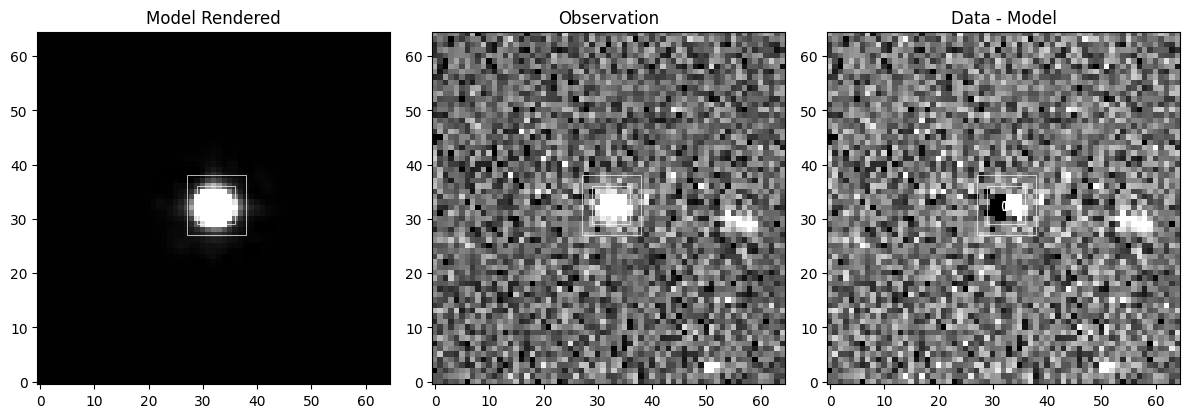

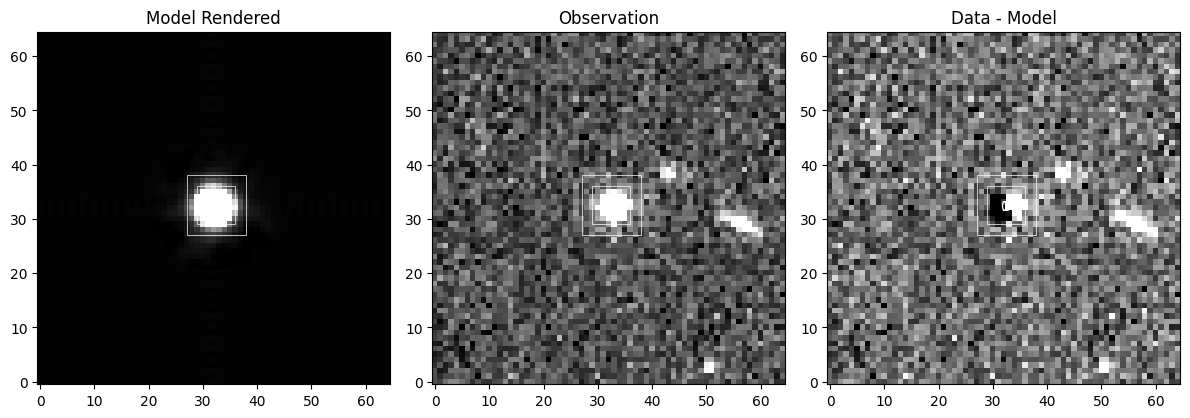

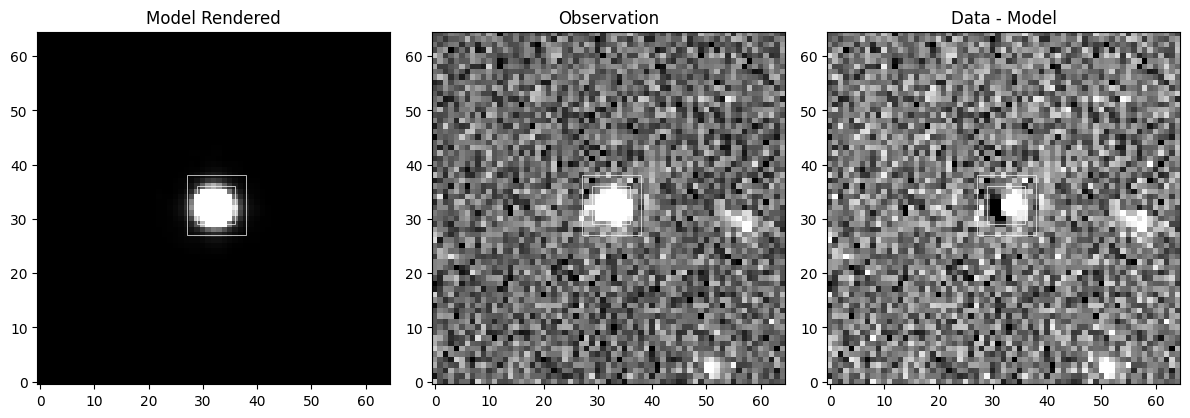

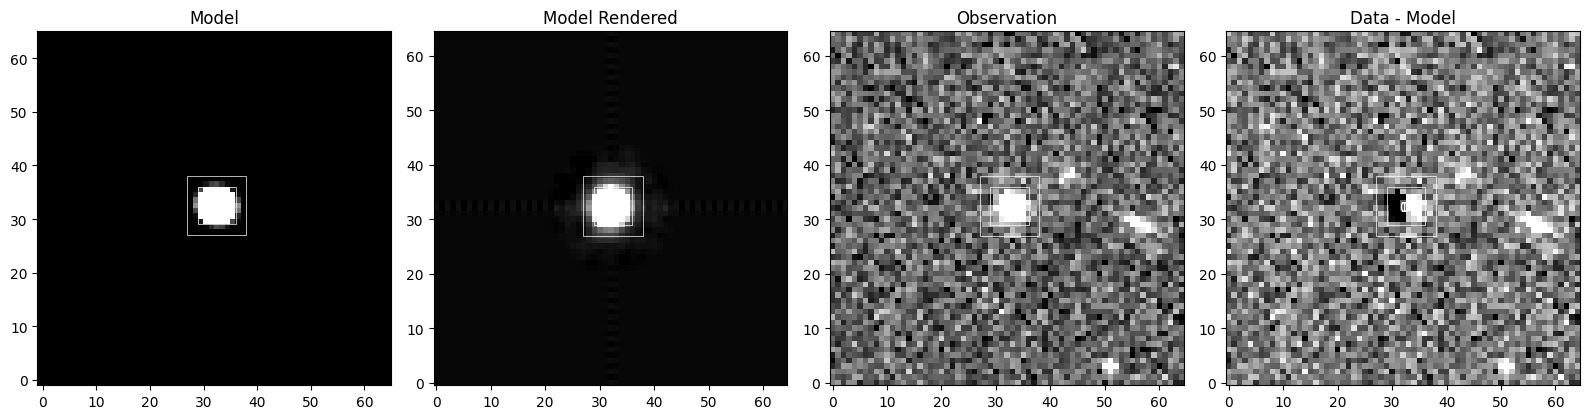

In [31]:
#Plot the initializations, for each observation
scarlet2.plot.scene(
    scene,
    observation=observations[0],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

scarlet2.plot.scene(
    scene,
    observation=observations[1],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()


scarlet2.plot.scene(
    scene,
    observation=observations[2],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

scarlet2.plot.scene(
    scene,
    observation=observations[3],
    norm=None,
    channel_map=None,
    show_model=True,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

In [32]:
n_steps, peak_value = stepnum, 1
schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
#Fit the scene
scene_ = scene.fit(observations, parameters,max_iter=stepnum, e_rel=1e-10, schedule=None)#schedule)

100%|██████████| 2000/2000 [01:40<00:00, 19.99it/s, loss=23670.40, max_change=0.000444]


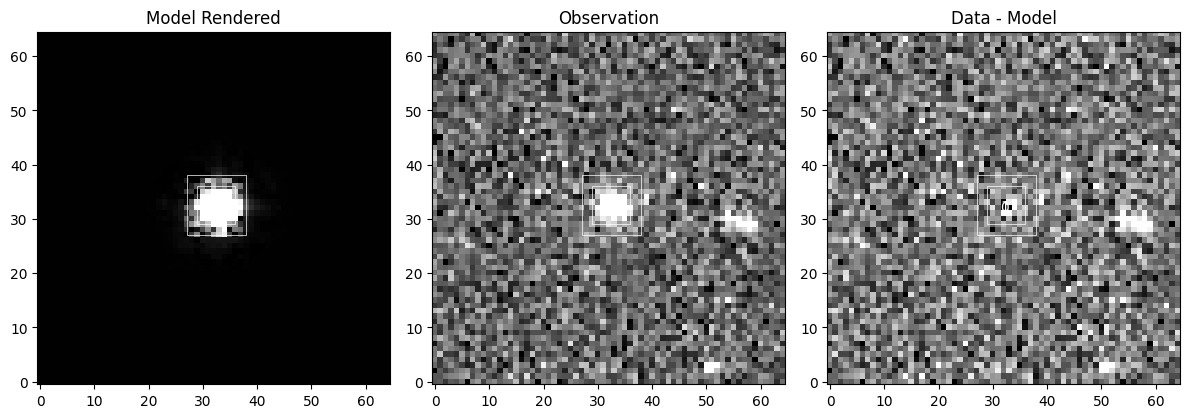

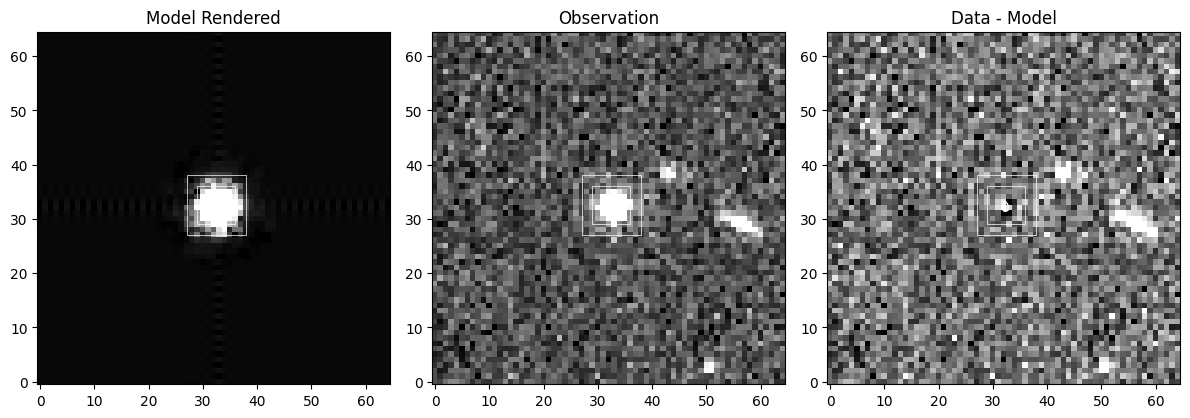

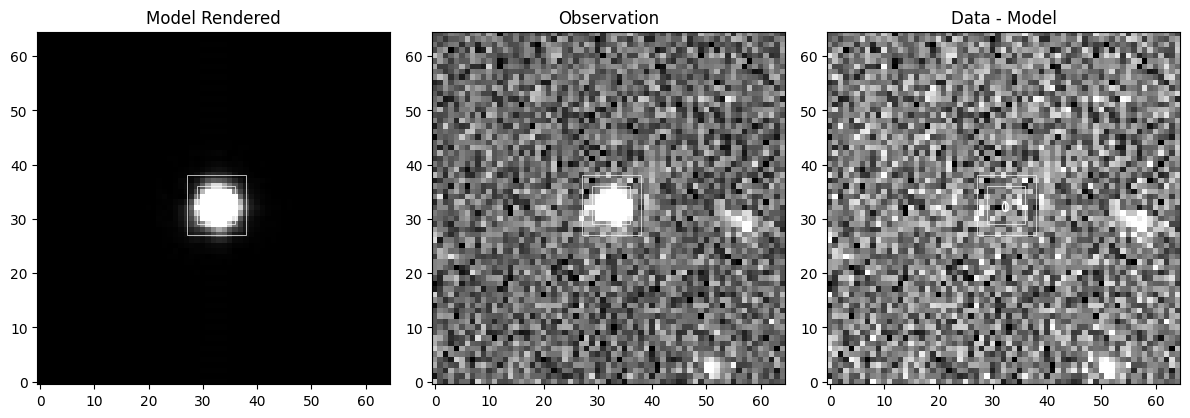

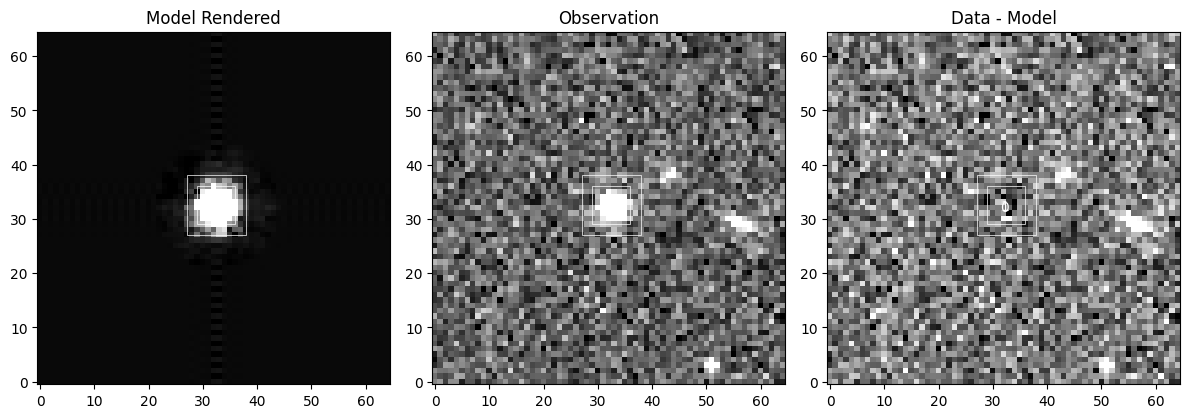

In [33]:
#Plot the fitted scenes: one for each observation
scarlet2.plot.scene(
    scene_,
    observation=observations[0],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

scarlet2.plot.scene(
    scene_,
    observation=observations[1],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

scarlet2.plot.scene(
    scene_,
    observation=observations[2],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

scarlet2.plot.scene(
    scene_,
    observation=observations[3],
    norm=None,
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

In [34]:
#Print the fluxes. The transient, source 0, has zero flux in the epochs where we forced it to be 'off'. The galaxy has the same flux in each epoch of the same band.
print ("----------------- {}".format(channels))
#Initialization values
for k, src in enumerate(scene.sources):
    print ("Source {}, Fluxes: {}".format(k, scarlet2.measure.flux(src)))
#Final fitted values
for k, src in enumerate(scene_.sources):
    print ("Source {}, Fluxes: {}".format(k, scarlet2.measure.flux(src)))

----------------- [('g', '0'), ('r', '0'), ('g', '1'), ('r', '1')]
Source 0, Fluxes: [  0.        0.      215.56984 514.24725]
Source 1, Fluxes: [2038.715 3779.712 2038.715 3779.712]
Source 0, Fluxes: [  0.        0.      848.9396  683.31134]
Source 1, Fluxes: [1899.934  3759.8398 1899.934  3759.8398]
